# U-Net: Redes neuronales convolucionales para segmentación de imágenes biomédicas

Pontificia Universidad Católica del Perú

Escuela de Posgrado PUCP, Maestría en Informática, Ciencias de la Computacion

Curso: 
- Técnicas avanzadas de data mining y sistemas inteligentes

Alumnos:
- 20173589 Alarcon Flores, Jorge Brian
- 20173685 Chicchón Apaza, Miguel Angel
- 20173789 Alvarez Mouravskaia, Kevin
- 20173810 Pacheco Condori, Jesús Edwar

---

## Línea base

- [1] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” CoRR, vol. abs/1505.0, 2015.
- [2] J. Akeret, C. Chang, A. Lucchi, and A. Refregier, “Radio frequency interference mitigation using deep convolutional neural networks,” Astron. Comput., vol. 18, pp. 35–39, 2017.

## Importación de librerías

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import tensorflow as tf
import logging
from collections import OrderedDict
import os
import shutil
from PIL import Image
import h5py
from PIL import Image
import wget #pip install wget

C:\Users\Kevin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


##### Configuración de logs

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

# Arquitectura de Red Neuronal UNET

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

La arquitectura consiste de una primera parte "contraccion" (Lado izquierdo) y una "expansion" (Lado derecho). 
- La parte de contraccion sigue la arquitectura tipica de una red convolucional. Esta consiste de repetir la 
aplicacion de dos convoluciones 3x3 (unpadded convolucions), cada una seguida por una unidad de rectificacion 
lineal (ReLU) y una operacion de max pooling con stride 2x2 para el downsampling. En cada paso de downsampling 
doblamos el numero de canales de caracteristicas. 
- Cada paso del lado de expansion consiste en un upsampling 
del mapa de caracteristicas seguido por una convolucional 2x2 "up-convolutional" que divide en partes iguales 
el numero de canalaes caracteristicas, luego una concatenacion con el correspondiente mapa de caracteristicas
sesgado obtenido en la contraccion y dos convoluciones 3x3 cada uno seguido por una por un ReLU.
El sesgo (cropping) es necesario debido a la perdida de los pixeles del borde en cada convolucion. 
En la capa final se utiliza una convolucion de 1x1 para mapear cada 64 vector caracteristica al numero deseado 
de clases. 
- En total la red neuronal tiene 23 capas convolucionales. Para permitir ua salida del mapa segmentado sin fisuras, es importante seleccionar el ingreso de imagenes tales que las operaciones son aplicadas a la capa con un tamanio para "x" y "y".

---

## Implementación de tf_unet
- Obtenido de (Akered, 2017)
- Código: https://github.com/jakeret/tf_unet

### util.py
Obtenido de (Akered, 2017)

In [4]:
def plot_prediction(x_test, y_test, prediction, save=False): 
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_2d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()

        
def to_rgb(img): 
    #Función que nos permite convertir una matriz en una imagen RGB
    #param img: la matriz que se va a convertir en la imagen RGB
    
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:    #La matriz debe tener 3 canales.
        img = np.tile(img, 3) #En caso de no tener 3 canales, se realiza una transformación mediante la función np.tile
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255          #Finalmente, los valores son reescalados al rango de [0,255) 
    return img  ##Retorna la imagen RGB


def crop_to_shape(data, shape): 
    #Recorta la matriz a la forma de imagen dada quitando el borde
    #:param data: la matriz a recortar
    #:param shape: la forma objetivo del recorte
    
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    return data[:, offset0:(-offset0), offset1:(-offset1)]


def combine_img_prediction(data, gt, pred): 
    #Combina los datos, mejorando la precisión de la predicción en la imagen RGB
    #:param data: parámetro referente a la data a analizar
    #:param gt: parámetro "grouth thruth"; en deep learning, el término "grouth thruth" se refiere a la acción de
                #predicción de la clasificación del conjunto de entrenamiento
    #:param pred: parámetro predicción
   
    ny = pred.shape[2]
    ch = data.shape[3]
    img = np.concatenate((to_rgb(crop_to_shape(data, pred.shape).reshape(-1, ny, ch)), 
                          to_rgb(crop_to_shape(gt[..., 1], pred.shape).reshape(-1, ny, 1)), 
                          to_rgb(pred[..., 1].reshape(-1, ny, 1))), axis=1)
    return img #Retorna la imagen concatenada de RGB


def save_image(img, path): 
    #función que guarda la imagen
    #:param img: la imagen RGB a guardar
    #:param path: la ruta objetivo donde se guardará la imagen RGB
    
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'JPEG', dpi=[300,300], quality=90)

### layers.py
Obtenido de (Akered, 2017)

In [5]:
def weight_variable(shape, stddev=0.1, name="weight"):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)

def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)

def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)

def deconv2d(x, W,stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)

def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")

### Unet
Obtenido de (Akered, 2017)

In [6]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
                    summaries=True):
                    #Función que nos permite crear una nueva red unet convolucional para la parametrización dada.
    
                    #:param x: tensor input [?,nx,ny,channels]
                    #:param keep_prob: probabilidad marginal del tensor
                    #:param channels: número de canales en la imagen input
                    #:param n_class: número de etiquetas output
                    #:param layers: número de capas en la red
                    #:param features_root: número de capas en la primera red
                    #:param filter_size: tamaño del filtro de convolución
                    #:param pool_size: tamaño de la operación del max pooling
  

    logging.info(
        "Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(
            layers=layers,
            features=features_root,
            filter_size=filter_size,
            pool_size=pool_size))

    # Marcador de posición para la imagen input
    with tf.name_scope("preprocessing"):
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        x_image = tf.reshape(x, tf.stack([-1, nx, ny, channels]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]

    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()

    in_size = 1000
    size = in_size

    for layer in range(0, layers):
        with tf.name_scope("down_conv_{}".format(str(layer))):
            features = 2 ** layer * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            if layer == 0:
                w1 = weight_variable([filter_size, filter_size, channels, features], stddev, name="w1")
            else:
                w1 = weight_variable([filter_size, filter_size, features // 2, features], stddev, name="w1")

            w2 = weight_variable([filter_size, filter_size, features, features], stddev, name="w2")
            b1 = bias_variable([features], name="b1")
            b2 = bias_variable([features], name="b2")

            conv1 = conv2d(in_node, w1, b1, keep_prob)
            tmp_h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(tmp_h_conv, w2, b2, keep_prob)
            dw_h_convs[layer] = tf.nn.relu(conv2)

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size -= 4
            if layer < layers - 1:
                pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                in_node = pools[layer]
                size /= 2

    in_node = dw_h_convs[layers - 1]

   
    for layer in range(layers - 2, -1, -1):
        with tf.name_scope("up_conv_{}".format(str(layer))):
            features = 2 ** (layer + 1) * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))

            wd = weight_variable_devonc([pool_size, pool_size, features // 2, features], stddev, name="wd")
            bd = bias_variable([features // 2], name="bd")
            h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
            h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
            deconv[layer] = h_deconv_concat

            w1 = weight_variable([filter_size, filter_size, features, features // 2], stddev, name="w1")
            w2 = weight_variable([filter_size, filter_size, features // 2, features // 2], stddev, name="w2")
            b1 = bias_variable([features // 2], name="b1")
            b2 = bias_variable([features // 2], name="b2")

            conv1 = conv2d(h_deconv_concat, w1, b1, keep_prob)
            h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(h_conv, w2, b2, keep_prob)
            in_node = tf.nn.relu(conv2)
            up_h_convs[layer] = in_node

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size *= 2
            size -= 4

    # Mapa Output
    with tf.name_scope("output_map"):
        weight = weight_variable([1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class], name="bias")
        conv = conv2d(in_node, weight, bias, tf.constant(1.0))
        output_map = tf.nn.relu(conv)
        up_h_convs["out"] = output_map

    if summaries:
        with tf.name_scope("summaries"):
            for i, (c1, c2) in enumerate(convs):
                tf.summary.image('summary_conv_%02d_01' % i, get_image_summary(c1))
                tf.summary.image('summary_conv_%02d_02' % i, get_image_summary(c2))

            for k in pools.keys():
                tf.summary.image('summary_pool_%02d' % k, get_image_summary(pools[k]))

            for k in deconv.keys():
                tf.summary.image('summary_deconv_concat_%02d' % k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%02d" % k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s" % k + '/activations', up_h_convs[k])

    variables = []
    for w1, w2 in weights:
        variables.append(w1)
        variables.append(w2)

    for b1, b2 in biases:
        variables.append(b1)
        variables.append(b2)

    return output_map, variables, int(in_size - size)

In [7]:
#Implementación de unet
#######################

class Unet(object): 
 
    
    def __init__(self, channels=3, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs): 
        #Inicializamos y definimos parámetros
        tf.reset_default_graph()  

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        self.y = tf.placeholder("float", shape=[None, None, None, n_class], name="y")
        self.keep_prob = tf.placeholder(tf.float32, name="dropout_probability")  # Probabilidad marginal

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)

        self.cost = self._get_cost(logits, cost, cost_kwargs)

        self.gradients_node = tf.gradients(self.cost, self.variables)

        with tf.name_scope("cross_entropy"):
            self.cross_entropy = cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                               tf.reshape(pixel_wise_softmax(logits), [-1, n_class]))

        with tf.name_scope("results"):
            self.predicter = pixel_wise_softmax(logits)
            self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

            
            
    def _get_cost(self, logits, cost_name, cost_kwargs): 
        #Construimos la función de costo

        with tf.name_scope("cost"):
            flat_logits = tf.reshape(logits, [-1, self.n_class])
            flat_labels = tf.reshape(self.y, [-1, self.n_class])
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights)
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                          labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map)

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                                     labels=flat_labels))
            elif cost_name == "dice_coefficient":
                eps = 1e-5
                prediction = pixel_wise_softmax(logits)
                intersection = tf.reduce_sum(prediction * self.y)
                union = eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
                loss = -(2 * intersection / (union))

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None) #Proceso de regularización
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

            return loss

    
    def predict(self, model_path, x_test):  
        #Utilizamos el modelo para crear una predicción para los datos dados
       
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Inicializamos las variables
            sess.run(init)

            # Restaura los pesos del modelo guardado previamente
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction 
    
    
    def save(self, sess, model_path): 
        #Guarda la sesión actual en un checkpoint
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path): 
        #Restaura la sesión de un checkpoint
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [8]:
def _update_avg_gradients(avg_gradients, gradients, step):
    if avg_gradients is None:
        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
    for i in range(len(gradients)):
        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step + 1)))) + (gradients[i] / (step + 1))

    return avg_gradients


def error_rate(predictions, labels): 
    #Devuelve la tasa de error en base a las predicciones densas 
    return 100.0 - ( 100.0 * np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) / 
                    (predictions.shape[0] * predictions.shape[1] * predictions.shape[2]))


def get_image_summary(img, idx=0): 
    #Genera un resumen de la imagen para la imagen del tensor 4d con el índice idx

    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255

    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

In [9]:
class Trainer(object): 
    #Entrena una instancia de unet

    def __init__(self, net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.verification_batch_size = verification_batch_size
        self.norm_grads = norm_grads
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs

    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)

            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate,
                                                                 global_step=global_step,
                                                                 decay_steps=training_iters,
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,
                                                                               global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate, name="learning_rate")

            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node,
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                           global_step=global_step)

        return optimizer

    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0, name="global_step")

        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]), name="norm_gradients")

        if self.net.summaries and self.norm_grads:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()
        init = tf.global_variables_initializer()

        self.prediction_path = prediction_path
        abs_prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)

        if not restore:
            logging.info("Removing '{:}'".format(abs_prediction_path))
            shutil.rmtree(abs_prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)

        if not os.path.exists(abs_prediction_path):
            logging.info("Allocating '{:}'".format(abs_prediction_path))
            os.makedirs(abs_prediction_path)

        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)

        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1,
              restore=False, write_graph=False, prediction_path='prediction'):
         # Se realiza el proceso de entrenamiento del modelo
        
        save_path = os.path.join(output_path, "model.ckpt")
        if epochs == 0:
            return save_path

        init = self._initialize(training_iters, output_path, restore, prediction_path)

        with tf.Session() as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)

            sess.run(init)

            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)

            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape,_,_,_ = self.store_prediction(sess, test_x, test_y, "_init")

            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")

            avg_gradients = None
            
            # Listas para almacenar las metricas
            losses_train = []
            losses_val = []
            accs_train = []
            accs_val = []
            lrs_train = []
            lrs_val = []
            
            for epoch in range(epochs):
                total_loss = 0
                total_acc = 0  # para acumular accuracy
                for step in range((epoch * training_iters), ((epoch + 1) * training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)
                    # loss, acc, lr -> por iteracion
                    _, loss, acc, lr, gradients = sess.run((self.optimizer, self.net.cost, self.net.accuracy,
                                                            self.learning_rate_node, self.net.gradients_node),
                                                           feed_dict={self.net.x: batch_x, self.net.y: crop_to_shape(batch_y, pred_shape),
                                                                      self.net.keep_prob: dropout})

                    if self.net.summaries and self.norm_grads:
                        avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
                        norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                        self.norm_gradients_node.assign(norm_gradients).eval()

                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x,
                                                    crop_to_shape(batch_y, pred_shape))

                    total_loss += loss
                    total_acc += acc # acumulando accuracy

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                # validacion
                _, loss_val, acc_val, lr_val = self.store_prediction(sess, test_x, test_y, "epoch_%s" % epoch)
                
                # agregando metricas de una epoca
                losses_train.append(total_loss/training_iters)
                accs_train.append(total_acc/training_iters)
                lrs_train.append(lr)
                losses_val.append(loss_val)
                accs_val.append(acc_val)
                lrs_val.append(lr_val)

                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            # Variable de salida para metricas
            data_metric = [losses_train, accs_train, lrs_train, losses_val,  accs_val,  lrs_val ]

            return save_path, data_metric

    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,
                                                             self.net.y: batch_y,
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape
        
        # loss, acc, lr -> validacion
        loss, acc, lr = sess.run((self.net.cost, self.net.accuracy, self.learning_rate_node), feed_dict={self.net.x: batch_x,
                                                  self.net.y: crop_to_shape(batch_y, pred_shape),
                                                  self.net.keep_prob: 1.})

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                                   crop_to_shape(batch_y,
                                                                                                      prediction.shape)),
                                                                        loss))

        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg" % (self.prediction_path, name))

        # retorna loss, acc, lr
        return pred_shape, loss, acc, lr

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info(
            "Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculamos las métricas
        summary_str, loss, acc, predictions = sess.run([self.summary_op,
                                                        self.net.cost,
                                                        self.net.accuracy,
                                                        self.net.predicter],
                                                       feed_dict={self.net.x: batch_x,
                                                                  self.net.y: batch_y,
                                                                  self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info(
            "Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                           loss,
                                                                                                           acc,
                                                                                                           error_rate(
                                                                                                               predictions,
                                                                                                               batch_y)))
    

### image_util
Obtenido de (Akered, 2017)

In [10]:
class BaseDataProvider(object):
  #Clase base abstracta para la implementación de DataProvider. 
  #Esta implementación recorta automáticamente los datos y normaliza los valores a (0,1). 

    channels = 1
    n_class = 2    
    
    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf
        
    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx = train_data.shape[1]
        ny = train_data.shape[0]  
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalización
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
              return data, labels    
    
    def reset_ids(self):
        self._reset_ids();
        
    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
    
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
    
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
    
        return X, Y           

In [11]:
class SimpleDataProvider(BaseDataProvider):
    #Proveedor de datos simple para matrices (numpy).
    # Se supone que los datos y la etiqueta son una matriz numpy con las dimensiones
    # data '[n, X, Y, channels]', label '[n, X, Y, classes]''. Donde 'n' es el número de imágenes,
    # 'X', 'Y' del tamaño de la imagen.
    """
    :param data: data numpy array. Shape=[n, X, Y, channels]
    :param label: label numpy array. Shape=[n, X, Y, classes]
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, data, label, a_min=None, a_max=None, channels=1, n_class = 2):
        super(SimpleDataProvider, self).__init__(a_min, a_max)
        self.data = data
        self.label = label
        self.file_count = data.shape[0]
        self.n_class = n_class
        self.channels = channels

    def _next_data(self):
        idx = np.random.choice(self.file_count)
        return self.data[idx], self.label[idx]

In [12]:
class ImageDataProvider(BaseDataProvider):
    #Proveedor de datos genérico para imágenes, admite escala de grises e imágenes en color.
    
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif', shuffle_data=True, n_class = 2):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        self.data_suffix = data_suffix
        self.mask_suffix = mask_suffix
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame
        self.shuffle_data = shuffle_data
        self.n_class = n_class
        self.data_files = self._find_data_files(search_path)
        
        if self.shuffle_data:
            np.random.shuffle(self.data_files)
        
        assert len(self.data_files) > 0, "No training files"
        print("Number of files used: %s" % len(self.data_files))
        
        img = self._load_file(self.data_files[0])
        self.channels = 1 if len(img.shape) == 2 else img.shape[-1]
        
    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return [name for name in all_files if self.data_suffix in name and not self.mask_suffix in name]
    
    def _load_file(self, path, dtype=np.float32):
        img = np.array(Image.open(path), dtype)
        return img
    
    def _load_tif_file(self, path):
        img_tif = Image.open(path)
        return img_tif

    #Método modificado para soportar frames en los TIF
    def _cylce_file(self):
        if self.file_n_frames == (self.file_frame_idx + 1):
            self.file_idx += 1
            self.file_frame_idx = 0
            if self.file_idx >= len(self.data_files):
                self.file_idx = 0
                self.file_frame_idx = 0
                if self.shuffle_data:
                    np.random.shuffle(self.data_files)
        else:
            self.file_frame_idx += 1
            
        if self.file_idx == -1:
            self.file_idx = 0

    #Método modificado para soportar frames en los TIF
    def _next_data(self):
        self._cylce_file()
        image_name = self.data_files[self.file_idx]
        label_name = image_name.replace(self.data_suffix, self.mask_suffix)
        tif_image = self._load_tif_file(image_name)
        tif_label = self._load_tif_file(label_name)
        self.file_n_frames = tif_image.n_frames
        
        if self.file_frame_idx == 0:
            self.file_n_frames_ids = np.arange(0, self.file_n_frames)
            np.random.shuffle(self.file_n_frames_ids)
            
        #print("Image name " + image_name + " - Frame Id: " + str(self.file_n_frames_ids[self.file_frame_idx]) + " - #Frame: " + str(self.file_frame_idx))
        tif_image.seek(self.file_n_frames_ids[self.file_frame_idx])
        tif_label.seek(self.file_n_frames_ids[self.file_frame_idx])
        
        img = np.array(tif_image, np.float32)
        label = np.array(tif_label, np.bool)
    
        return img,label
    
    #Nuevo metodo para reiniciar los ids
    def _reset_ids(self):
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame

### image_gen
Obtenido de (Akered, 2017)

In [13]:
def create_image_and_label(nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
        image = np.ones((nx, ny, 1))
        label = np.zeros((nx, ny, 3), dtype=np.bool)
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt):
            a = np.random.randint(border, nx-border)
            b = np.random.randint(border, ny-border)
            r = np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            y,x = np.ogrid[-a:nx-a, -b:ny-b]
            m = x*x + y*y <= r*r
            mask = np.logical_or(mask, m)

            image[m] = h

        label[mask, 1] = 1

        if rectangles:
            mask = np.zeros((nx, ny), dtype=np.bool)
            for _ in range(cnt//2):
                a = np.random.randint(nx)
                b = np.random.randint(ny)
                r =  np.random.randint(r_min, r_max)
                h = np.random.randint(1,255)

                m = np.zeros((nx, ny), dtype=np.bool)
                m[a:a+r, b:b+r] = True
                mask = np.logical_or(mask, m)
                image[m] = h

            label[mask, 2] = 1

            label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

        image += np.random.normal(scale=sigma, size=image.shape)
        image -= np.amin(image)
        image /= np.amax(image)

        if rectangles:
            return image, label
        else:
            return image, label[..., 1] 

In [14]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)   
    
    def _reset_ids(self):
        self

# Entrenamiento y pruebas
Pruebas con diferentes conjuntos de datos
- Utilizar imágenes del formato TIFF. 
- Se recomienda visualizar las imágenes con el siguiente editor: https://fiji.sc/
- Cada prueba tiene una variable que comienza con ENTRENAR (Ej. ENTRENAR_BROAD_TOY_PROBLEM_MODEL). Esa variable indica si vamos a reutilizar un modelo ya entrenado o vamos a entrenar de nuevo. Se recomienda que sea True al entrenar y luego pasarlo a False. 

### Implementacion de U-Net con Tensorflow


#### Paso1: Definimos la red UNET

- Definimos la red U-Net

```python
Unet(channels=3, n_class=2, cost=u'cross_entropy', cost_kwargs={}, **kwargs)
```

- Donde:	
    - channels:(Opcional) Numero de canales en la imagen de entrada
    - n_class: (Opcional) Numero de clases de salida.
    - cost:(Opcional) Nombre de la funcion de costo. Por defecto es ‘cross_entropy’
    - cost_kwargs: (Opcional) Argumentos para la funcion costo. Ver funcion costo.
    
    - Ejemplo:
    ```python
net = Unet(channels=1, n_class=2, layers=3, features_root=64)
    ```

    - channels: Como utilizamos imagenes en escala de grises, se asigno el valor de channels=1. Para el caso de utilizar imagenes en color RGB, el numero de canales deberia ser channels=3.
    - n_class: El objetivo de la U-Net es predecir un problema binario, por l que las clases se asignarion a class=2.
    - layers: El numero de capas  o niveles de la arquitectura de la UNET se definio a Layers=3.
    - features_root: El numero de caracteristicas en la primera capa, por lo que features_root=16

#### Paso 2: Definimos el Entrenamiento 

- Definimos el objeto de entrenamiento

```python
trainer = Trainer(net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}
```

- Donde:
    - net: Es la instancia a entrenar.
    - batch_size: Es el tamanio batch a entrenar, para dataset con gran volumen de data.
    - verification_batch_size: (Opcional) tamanio de verifiacion del batch. Valor por defecto 4.
    - norm_grads: (Opcional) true si las gradientes normalizadas deberia ser agregados al resumen, por defecto False.
    - optimizer: (Opcional) nombre del optimizador a utilizar peude ser momentum or adam, por defecto el primero.
    - opt_kwargs: (Opcional) kwargs pasado para el grado de aprendiazje (momentum opt) and al optimizador.

    - Ejemplo: 
    ```python
    trainer = Trainer(net, trainers_iters=32, epochs=100, batch_size=500)
    ```

#### Paso 3: Ejecutamos la red entrenada

- Definimos el objeto de Predicion

```python
prediction = model.predict(output_path, x_test)
```

- Donde:
    - output_path: indicandole la ruta donde se encuentra el archivo con el modelo entrenado.
    - x_test: Data a predecir en la red. De la forma [n, nx, ny, channels]

    - Ejemplo: 
    ```python
    prediction = model.predict(output_path, x_test)
    ```

In [41]:
#######################################
#Fuente: elaboración propia
#Clase que se invoca para entrenar los modelos y probarlos
#######################################
class Pruebas():
    
    def get_image_plt(self, image_array, index):
        return to_rgb(image_array[0,...,index]).round().astype(np.uint8)
    
    def train(self, data_provider, trained_folder, training_iters=32, epochs=10, batch_size=1, 
              layers=3, features=16, momentum=0.2, train = True):
        #TODO: solo muestra la primera imagen
        x_train, y_train = data_provider(1)   
        
        #Convertimos las imagenes para no perder información al graficar
        x_img = self.get_image_plt(x_train, 0)
        y_img = self.get_image_plt(y_train, 1)
        
        data_provider.reset_ids()
        
        #Graficar
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
        ax[0].imshow(x_img, aspect="auto")
        ax[1].imshow(y_img, aspect="auto") 
        plt.show()
        
        #Entrenar
        net = Unet(channels=data_provider.channels, n_class=data_provider.n_class, layers=layers, features_root=features)
        trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=momentum), batch_size=batch_size)
        data_metric = None
        if train:
            path, data_metric = trainer.train(data_provider, "./" + trained_folder, 
                                 training_iters = training_iters, 
                                 epochs = epochs, 
                                 display_step = 2, 
                                 prediction_path='prediction_' + trained_folder, 
                                 restore = True, 
                                 write_graph = True)
        return net, data_metric
        
    def test(self, model, data_provider, trained_folder):
        #TODO: solo muestra la primera imagen
        x_test, y_test = data_provider(1)
        #Predicción
        prediction = model.predict("./" + trained_folder + "/model.ckpt", x_test)
        
        #Convertimos las imagenes para no perder información al grafica
        x_img = self.get_image_plt(x_test, 0)
        y_img = self.get_image_plt(y_test, 1)
        pred_img = self.get_image_plt(prediction, 1)
        
        #Graficar
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
        ax[0].set_title("Input")
        ax[1].set_title("Ground truth")
        ax[2].set_title("Prediction")
        
        ax[0].imshow(x_img, aspect="auto")
        ax[1].imshow(y_img, aspect="auto")
        ax[2].imshow(pred_img, aspect="auto")
        fig.tight_layout()
        
        #Guardamos imagen para documentación
        fig.savefig("img/"+ "./" + trained_folder+".png")        
        

In [16]:
#######################################
#Fuente: elaboración propia
#Función para mostrar métricas
#######################################

def show_results(data_metric):
    losses_train = data_metric[0]
    accs_train   = data_metric[1]
    lrs_train     = data_metric[2]
    losses_val   = data_metric[3]
    accs_val     = data_metric[4]
    lrs_val       = data_metric[5]
        
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    ax1, ax2, ax3 = axes
    ax1.plot(losses_train, label='train')
    ax1.plot(losses_val, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(accs_train, label='train')
    ax2.plot(accs_val, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    ax3.plot(lrs_train, label='train')
    ax3.plot(lrs_val, label='test')
    ax3.set_xlabel('epoch'); ax3.set_ylabel('learning rate')
    for ax in axes: ax.legend()

### demo_toy_problem
- Demos obtenidos del repositorio https://github.com/jakeret/tf_unet
- Crea una imágen con valores aleatóreos

In [42]:
TRAINED_FOLDER_TOY_PROBLEM = "unet_trained_toy_problem"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_TOY_PROBLEM_MODEL = False

In [43]:
def generar_toy_image():
    nx = 572
    ny = 572
    plt.rcParams['image.cmap'] = 'gist_earth'
    np.random.seed(98765)
    return GrayScaleDataProvider(nx, ny, cnt=20);

Train

In [44]:
data_provider_toy_problem_train = generar_toy_image()

In [45]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_toy_problem = Pruebas();

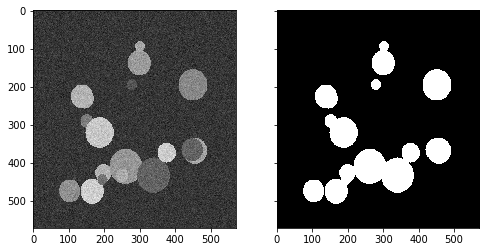

2018-10-06 10:05:44,644 Layers 5, features 32, filter size 3x3, pool size: 2x2


In [46]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_toy_problem, data_metric = pruebas_toy_problem.train(data_provider_toy_problem_train, 
                                              TRAINED_FOLDER_TOY_PROBLEM, 
                                              32, #iterations
                                              10, #epoch
                                              1, #batch size
                                              5, #layers
                                              32, #features
                                              0.5, #momentum
                                              ENTRENAR_BROAD_TOY_PROBLEM_MODEL)

Métricas

In [47]:
if (data_metric is not None):
    show_results(data_metric)

Test

In [48]:
data_provider_toy_problem_test = data_provider_toy_problem_train

INFO:tensorflow:Restoring parameters from ./unet_trained_toy_problem/model.ckpt


2018-10-06 10:06:14,927 Restoring parameters from ./unet_trained_toy_problem/model.ckpt
2018-10-06 10:06:15,027 Model restored from file: ./unet_trained_toy_problem/model.ckpt


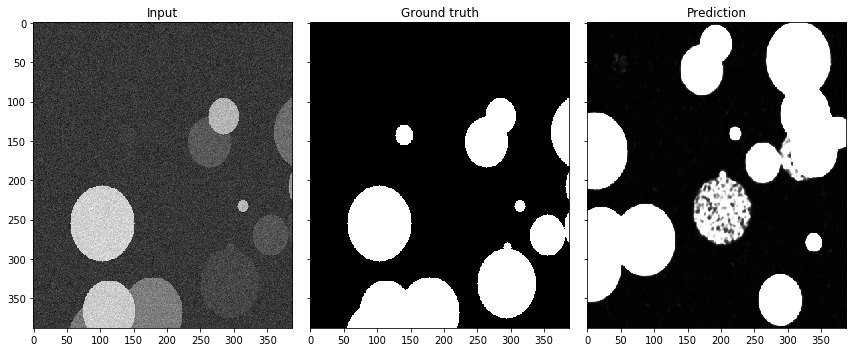

In [49]:
pruebas_toy_problem.test(model_toy_problem, data_provider_toy_problem_test, TRAINED_FOLDER_TOY_PROBLEM)

### EM segmentation challenge - ISBI 2012 (línea base)
- http://brainiac2.mit.edu/isbi_challenge/
- Es la que usan en el paper base (Ronneberger et al., 2015)
- Resolución: 512 x 512 x 30
- No existen imágenes de máscaras para conjunto de pruebas

In [ ]:
PATH_ISBI_2012_TRAIN = "dataset/isbi-challenge/train/"
PATH_ISBI_2012_TEST_ORIGINAL = "dataset/isbi-challenge/test-original/"
PATH_ISBI_2012_TEST_MASK = "dataset/isbi-challenge/test-mask/"
TRAINED_FOLDER_ISBI_2012 = "unet_trained_isbi_2012"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_ISBI_2012_MODEL = False

Train

In [ ]:
#######################################
#Fuente: elaboración propia
#Clase para separar los frames que una imagen TIF
#Util cuando no se tiene imágenes de test
#######################################
class ImageSeparator:
    
    def borrar_archivos(self, path):
        for root, dirs, files in os.walk(path):
            for file in files:
                os.remove(os.path.join(root, file))   
    
    def separar_tif(self, image_path_train, image_path_label, path_copy):
        
        path_train = path_copy + "train"
        path_test = path_copy + "test-mask"
        
        #obtenemos las imágenes y las guardamos en un arreglo
        ids = []
        images_train = []
        tif_image = Image.open(image_path_train)
        n_frames = tif_image.n_frames
        print("La imagenes tiene: " + str(n_frames) + " frames/capas")
        for i in range(0, n_frames):
            tif_image.seek(i)
            ids.append(i)
            images_train.append(tif_image.copy())
            
        #obtenemos las imágenes de los label y las guardamos en un arreglo
        images_label = []
        tif_label = Image.open(image_path_label)
        for i in range(0, n_frames):
            tif_label.seek(i)
            images_label.append(tif_label.copy())            

        #mezclamos aleatoreamente el arreglo de imágenes
        np.random.seed(0) #cambiar la semilla si quieren generar de nuevo
        np.random.shuffle(ids)

        #separamos conjunto de entrenamiento (70%) y pruebas (30%)
        n_frames_train = int(n_frames * 0.7)
        print("Total de imágenes de entrenamiento (70%): " + str(n_frames_train))
        print("Total de imágenes de prueba (30%): " + str(n_frames - n_frames_train))

        #borramos los archivos actuales
        self.borrar_archivos(path_train)
        self.borrar_archivos(path_test)

        #guardamos las imágenes de entrenamiento
        for i in range(0, n_frames_train):
            new_name_file = path_copy + "train/train" + "-" + str(i)
            images_train[ids[i]].save(new_name_file + ".tif")
            images_label[ids[i]].save(new_name_file + "_mask.tif")

        #guardamos las imágenes de prueba    
        for i in range(n_frames_train, n_frames):
            new_name_file = path_copy + "test-mask/test" + "-" + str(i)
            images_train[ids[i]].save(new_name_file + ".tif")
            images_label[ids[i]].save(new_name_file + "_mask.tif")
            
        print("Fin de proceso")

    def separarImagenesIsbiChallenge(self, generar):
        if generar:
            #Las imágenes de entrenamiento tienen que tener la misma cantidad de capas que los labels
            IMAGE_PATH_TRAIN = "dataset/isbi-challenge/original/train-volume.tif"
            IMAGE_PATH_LABEL = "dataset/isbi-challenge/original/train-labels.tif"
            self.separar_tif(IMAGE_PATH_TRAIN, IMAGE_PATH_LABEL, "dataset/isbi-challenge/")            

In [ ]:
imageSeparator = ImageSeparator()
#Pasar a false si ya tienen generadas las imágenes
imageSeparator.separarImagenesIsbiChallenge(False)

In [ ]:
data_provider_isbi_2012_train = ImageDataProvider(PATH_ISBI_2012_TRAIN + "*.tif")

In [ ]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_isbi_2012 = Pruebas();

In [ ]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_isbi_2012, data_metric_isbi_2012 = pruebas_isbi_2012.train(data_provider_isbi_2012_train, 
                                          TRAINED_FOLDER_ISBI_2012, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum
                                          ENTRENAR_BROAD_ISBI_2012_MODEL)

Test
- Este conjunto de prueba no tiene labels con cual comparar

Métricas

In [ ]:
if (data_metric_isbi_2012 is not None):
    show_results(data_metric_isbi_2012)

In [ ]:
data_provider_isbi_2012_test = ImageDataProvider(PATH_ISBI_2012_TEST_ORIGINAL + "*.tif")

In [ ]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test, TRAINED_FOLDER_ISBI_2012)

Test
- Utilizamos los labels reservados de la imagen original para poder hacer las comparaciones

In [ ]:
data_provider_isbi_2012_test_mask = ImageDataProvider(PATH_ISBI_2012_TEST_MASK + "*.tif")

In [ ]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test_mask, TRAINED_FOLDER_ISBI_2012)

### Cell Tracking Challenge (línea base)
- http://www.celltrackingchallenge.net/datasets.html
- Solo existe una imagen sin máscara
- Se necesitan buscar reemplazos de ambos conjuntos

PhC-U373 - PhC-C2DH-U373
- Glioblastoma-astrocytoma U373 cells on a polyacrylimide substrate  (2D)
- Dr. Sanjay Kumar. Department of Bioengineering
- University of California at Berkeley. Berkeley CA (USA)
- Microscope: Nikon
- Objective lens: Plan Fluor DLL 20X/0.5
- Pixel size (microns): 0.65 x 0.65
- Time step (min): 15

In [ ]:
img = Image.open("img/PhC-C2DH-U373.gif")
img = img.resize((300, 250), Image.ANTIALIAS)
img

DIC-HeLA - Fluo-N2DL-HeLa
- HeLa cells stably expressing H2b-GFP (2D)
- Mitocheck Consortium
- Microscope: Olympus IX81
- Objective lens: Plan 10x/0.4
- Pixel size (microns): 0.645 x 0.645
- Time step (min): 30

In [ ]:
img = Image.open("img/N2DL-HeLa.gif")
img = img.resize((400, 250), Image.ANTIALIAS)
img

### Broad Bioimage Benchmark Collection (BBBC003)
- Embriones de ratones.
- Modo de toma: Fluor
- https://data.broadinstitute.org/bbbc/BBBC003/
- Existen diferentes conjuntos de datos
- Todas las imágenes deben tener la misma orientación (horizontal o vertical). Se modificaron manualmente.

In [ ]:
PATH_BROAD_003_TRAIN = "dataset/broad-bioimage/BBBC003/train/"
PATH_BROAD_003_TEST = "dataset/broad-bioimage/BBBC003/test/"
TRAINED_FOLDER_BROAD_003 = "unet_trained_broad_003"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_003_MODEL = False 

Train

In [ ]:
data_provider_broad_003_train = ImageDataProvider(PATH_BROAD_003_TRAIN + "*.tif")

In [ ]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_003 = Pruebas();

In [ ]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_003, data_metric_broad_003 = pruebas_broad_003.train(data_provider_broad_003_train, 
                                          TRAINED_FOLDER_BROAD_003, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum 
                                          ENTRENAR_BROAD_003_MODEL)

Métricas

In [ ]:
if (data_metric_isbi_2012 is not None):
    show_results(data_metric_isbi_2012)

Test

In [ ]:
data_provider_broad_003_test = ImageDataProvider(PATH_BROAD_003_TEST + "*.tif")

In [ ]:
pruebas_broad_003.test(model_broad_003, data_provider_broad_003_test, TRAINED_FOLDER_BROAD_003)

### Broad Bioimage Benchmark Collection (BBBC005)
- https://data.broadinstitute.org/bbbc/image_sets.html
- Existen diferentes conjuntos de datos

In [ ]:
PATH_BROAD_005_TRAIN = "dataset/broad-bioimage/BBBC005/train/"
PATH_BROAD_005_TEST = "dataset/broad-bioimage/BBBC005/test/"
TRAINED_FOLDER_BROAD_005 = "unet_trained_broad_005"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_005_MODEL = False 

Train

In [ ]:
data_provider_broad_005_train = ImageDataProvider(PATH_BROAD_005_TRAIN + "*.tif")

In [ ]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_005 = Pruebas();

In [ ]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_005, data_metric_broad_005 = pruebas_broad_005.train(data_provider_broad_005_train, 
                                          TRAINED_FOLDER_BROAD_005, 
                                          32, #iterations
                                          20, #epoch
                                          1, #batch size
                                          5, #layers
                                          32, #features
                                          0.5, #momentum
                                          ENTRENAR_BROAD_005_MODEL)

Métricas

In [ ]:
if (data_metric_broad_005 is not None):
    show_results(data_metric_broad_005)

Test

In [ ]:
data_provider_broad_005_test = ImageDataProvider(PATH_BROAD_005_TEST + "*.tif")

In [ ]:
pruebas_broad_005.test(model_broad_005, data_provider_broad_005_test, TRAINED_FOLDER_BROAD_005)

###  Electron Microscopy Dataset
- Tomas del hipocampo
- Fuente: https://cvlab.epfl.ch/data/data-em/
- Resolución: 1024 x 768 x 165
- Podría ser utilizado como complemento del dataset EM segmentation challenge - ISBI 2012
- Se ha corrido con 10 épocas y aún no logra buenos resultados (hay que probarlo en la nube)

In [ ]:
PATH_ELECTRON_MICROSCOPY_TRAIN = "dataset/electron-microscopy/train/"
PATH_ELECTRON_MICROSCOPY_TEST = "dataset/electron-microscopy/test/"
TRAINED_FOLDER_ELECTRON_MICROSCOPY = "unet_trained_electron_microscopy"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_ELECTRON_MICROSCOPY_MODEL = False 

Los archivos pesan más de 100mb, por lo que no podremos integrarlos al repositorio. Se procede a descargarlos por única vez.

In [ ]:
#Descargar imágenes
URL_ELECTRON_MICROSCOPY_TRAIN = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training.tif"
URL_ELECTRON_MICROSCOPY_TRAIN_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training_groundtruth.tif"
URL_ELECTRON_MICROSCOPY_TEST = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing.tif"
URL_ELECTRON_MICROSCOPY_TEST_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing_groundtruth.tif"

def crear_carpetas():
    try:
        os.mkdir("dataset/electron-microscopy/")
        os.mkdir("dataset/electron-microscopy/train") 
        os.mkdir("dataset/electron-microscopy/test") 
        print("Las carpetas han sido creadas")
    except:
        print("Ya están creadas las carpetas")
        
def descargar_imagen(url, path):
    if not os.path.exists(path):
        print("Descargando " + path)
        wget.download(url=url, out=path)

In [ ]:
crear_carpetas()
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN, 'dataset/electron-microscopy/train/training.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN_MASK, 'dataset/electron-microscopy/train/training_mask.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST, 'dataset/electron-microscopy/test/testing.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST_MASK, 'dataset/electron-microscopy/test/testing_mask.tif')

Train

In [ ]:
data_provider_electron_microscopy_train = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TRAIN + "*.tif")

In [ ]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_electron_microscopy = Pruebas();

In [ ]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#Ej. 40 iteraciones x 4 batch size = 160 ejemplos. Tenemos 165 frames en la imagen
#Recomendaciones de batch: https://www.quora.com/What-are-the-usual-batch-sizes-people-use-to-train-neural-nets                     
#########################
model_electron_microscopy, data_metric_electron_microscopy = pruebas_electron_microscopy.train(data_provider_electron_microscopy_train, 
                                          TRAINED_FOLDER_ELECTRON_MICROSCOPY, 
                                          32, #iterations
                                          50, #epoch
                                          1, #batch size
                                          5, #layers
                                          16, #features
                                          0.5, #momentum 
                                          ENTRENAR_ELECTRON_MICROSCOPY_MODEL)

Métricas

In [ ]:
if (data_metric_electron_microscopy is not None):
    show_results(data_metric_electron_microscopy)

Test

In [ ]:
data_provider_electron_microscopy_test = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TEST + "*.tif")

In [ ]:
pruebas_electron_microscopy.test(model_electron_microscopy, 
                                 data_provider_electron_microscopy_test, 
                                 TRAINED_FOLDER_ELECTRON_MICROSCOPY)